#### MSC Geomet - Highlighting an error with the Accessing flow predictions data from Geomet

In [1]:
# data
import warnings
import re
import time
import configparser
from datetime import datetime, timedelta
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

# web map services 
from owslib.wms import WebMapService
from owslib.wcs import WebCoverageService
from owslib.wcs import Authentication

In [2]:
config = configparser.ConfigParser()
config.read_file(open('../config.cfg'))

login = config['Login']

In [3]:
# filter warnings or be prepared to see plenty
warnings.filterwarnings('ignore', module='owslib', category=UserWarning)

In [6]:
# use username and password parameters individually
# wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS&LAYERS={layer_name}',
wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS',
                    version='1.3.0',
                    username=login['Username'],
                    password=login['Password'],
                    timeout=300)

# let's check what data are available for the Water Cycle Prediction System (WCPS)
for key in list(wms.contents.keys()):
    if "WCPS" in key:
        print(key)

Water Cycle Prediction System (WCPS) [1 km]
WCPS-Ocean-Atmosphere
WCPS_1km_AirTemp_1.5m
WCPS_1km_MixedLayerThickness
WCPS_1km_Runoff
WCPS_1km_SeaIceAreaFraction
WCPS_1km_SeaIceCompressiveStrength
WCPS_1km_SeaIceDivergence
WCPS_1km_SeaIceInternalPressure
WCPS_1km_SeaIceShear
WCPS_1km_SeaIceSnowTemp
WCPS_1km_SeaIceSnowVol
WCPS_1km_SeaIceVelocity
WCPS_1km_SeaIceVol
WCPS_1km_SeaSfcHeight
WCPS_1km_SeaWaterPotentialTemp_0.5m
WCPS_1km_SeaWaterSalinity_0.5m
WCPS_1km_SeaWaterVelocity_0.5m
WCPS_1km_TurboclineDepth
WCPS_1km_WindsU_10m
WCPS_1km_WindsV_10m
WCPS_1km_Winds_10m


In [5]:
# layer_name = 'High Resolution Deterministic Precipitation Analysis (HRDPA) [2.5 km]'
# layer_name = 'Precipitation Analysis'
# layer_name = 'ALERTS'
layer_name = 'Regional Deterministic Precipitation Analysis (RDPA) [10 km]'

# Assuming 'wms[layer_name]._children' contains a list of ContentMetadata objects
children = getattr(wms[layer_name], "_children", [])

# Iterate over each ContentMetadata object in the list
for child in children:
    print(f"ContentMetadata Object: {child}")

    # Use vars() or dir() to inspect the attributes of each ContentMetadata object
    for key, value in vars(child).items():
        if value is not None:  # Only print attributes with values
            print(f"  {key}: {value}")

ContentMetadata Object: Layer Name: RDPA-Prelim_10km_Precip-Accum6h Title: RDPA - Quantity of precipitation over a 6h hour interval (preliminary) [mm] [10 km]
  auth: <Authentication shared=False username=None password=None cert=None verify=True auth_delegate=None>
  parent: Layer Name: Regional Deterministic Precipitation Analysis (RDPA) [10 km] Title: Regional Deterministic Precipitation Analysis (RDPA) [10 km]
  index: 1.11.2.1
  _children: []
  id: RDPA-Prelim_10km_Precip-Accum6h
  name: RDPA-Prelim_10km_Precip-Accum6h
  queryable: 1
  cascaded: 0
  opaque: 0
  noSubsets: 0
  fixedWidth: 0
  fixedHeight: 0
  title: RDPA - Quantity of precipitation over a 6h hour interval (preliminary) [mm] [10 km]
  abstract: The Regional Deterministic Precipitation Analysis (RDPA) produces a best estimate of the amount of precipitation that occurred over recent past periods of 6 or 24 hours. The estimate integrates data from in situ precipitation gauge measurements, weather radar, satellite imager

In [6]:
# layer_name = 'HRDPA-Prelim_2.5km_Precip-Accum6h'
# layer_name = 'HRDPA-Prelim_2.5km_Precip-Accum24h-T06Z'
# layer_name = 'HRDPA-Prelim_2.5km_Precip-Accum24h-T12Z'
# layer_name = 'HRDPA_2.5km_Precip-Accum6h'
# layer_name = 'HRDPA_2.5km_Precip-Accum24h-T06Z'
# layer_name = 'HRDPA_2.5km_Precip-Accum24h-T12Z'
layer_name = 'RDPA_10km_Precip-Accum6h'
# layer_name = 'ALERTS'
wcs = WebCoverageService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WCS&COVERAGEID={layer_name}',
                         auth=Authentication(username=login['Username'], password=login['Password']),
                         version='2.0.1',
                         timeout=300
                         )

In [7]:
# layer details
for key, value in vars(wms[layer_name]).items():
    if value:  # not all layers have values for the full set of available details
        print(key)  # print the attribute name
        print(getattr(wms[layer_name], key))  # dynamically access the value of the attribute using getattr


auth
<Authentication shared=False username=None password=None cert=None verify=True auth_delegate=None>
parent
Layer Name: Regional Deterministic Precipitation Analysis (RDPA) [10 km] Title: Regional Deterministic Precipitation Analysis (RDPA) [10 km]
index
1.11.2.10
id
RDPA_10km_Precip-Accum6h
name
RDPA_10km_Precip-Accum6h
queryable
1
title
RDPA - Quantity of precipitation over a 6h hour interval [mm] [10 km] (archive)
abstract
The Regional Deterministic Precipitation Analysis (RDPA) produces a best estimate of the amount of precipitation that occurred over recent past periods of 6 or 24 hours. The estimate integrates data from in situ precipitation gauge measurements, weather radar, satellite imagery and numerical weather prediction models. Geographic coverage is North America (Canada, United States and Mexico). Data is available at horizontal resolution of 10 km. Data is only available for the surface level. Analysis data is made available four times a day for 6h intervals and twice

In [8]:
# let's have a look at some of the details
print(wms[layer_name].title)
# print(wms[layer_name].dimensions)

# time metadata is stored in the dimensions attribute
print(wms[layer_name].boundingBox)
# print(wms[layer_name].defaulttimeposition)
# print(wms[layer_name].dimensions['time']['values'][0])

RDPA - Quantity of precipitation over a 6h hour interval [mm] [10 km] (archive)
(-180.0, -3.85657, 180.0, 90.0, 'EPSG:102978')


In [9]:
from pyproj import CRS, Transformer

# Example proj string for EPSG:102998 (check its actual definition)
source_crs = CRS.from_proj4("+proj=longlat +datum=WGS84 +no_defs")  # Replace with actual proj string
dest_crs = CRS.from_epsg(4326)  # Destination: WGS84 (EPSG:4326)

# Continue as before with transformation
transformer = Transformer.from_crs(source_crs, dest_crs, always_xy=True)


# Original bounding box: (min_x, min_y, max_x, max_y)
bounding_box = (-133.7, 27.3, -40.7, 66.6)

# Convert corners of bounding box from EPSG:102998 to EPSG:4326
min_lon, min_lat = transformer.transform(bounding_box[0], bounding_box[1])
max_lon, max_lat = transformer.transform(bounding_box[2], bounding_box[3])

print(f"Reprojected Bounding Box: ({min_lon}, {min_lat}, {max_lon}, {max_lat})")



Reprojected Bounding Box: (-133.7, 27.3, -40.7, 66.6)


In [10]:
# formatting the reference time information
first, last, interval = wms[layer_name].dimensions['time']['values'][0].split('/')

print('The first forecast issue is available at: ' + first)
print('The last forecast issue is available at: ' + last)
print('The forecast intervals are every: ' + interval)
print(type(first))

The first forecast issue is available at: 2023-07-05T12:00:00Z
The last forecast issue is available at: 2025-03-03T12:00:00Z
The forecast intervals are every: PT6H
<class 'str'>


In [11]:
# let's print the operations available from the wms and the product formatting options
for op in wms.operations:
    print(op.name, op.formatOptions)

GetCapabilities ['text/xml']
GetMap ['image/png', 'image/jpeg']
GetFeatureInfo ['text/plain', 'application/json', 'application/vnd.ogc.gml']
DescribeLayer ['text/xml']
GetLegendGraphic ['image/png', 'image/jpeg', 'image/png; mode=8bit', 'image/vnd.jpeg-png', 'image/vnd.jpeg-png8']
GetStyles ['text/xml']


In [12]:
wcs = WebCoverageService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WCS&COVERAGEID={layer_name}',
                         auth=Authentication(username=login['Username'], password=login['Password']),
                         version='2.0.1',
                         timeout=300
                         )

# layer details
# for key, value in vars(wcs[layer_name]).items():
#     if value is not None: # not all layers have values for the full set of available details
#         print(key) # let's just print the details applicable to this layer

In [13]:
# response = wcs.getCoverage(identifier=[layer_name],
#                            # format='image/png',
#                            # subsettingcrs='EPSG:4326',  # Default and recommended crs
#                         #   subsets = [('lat', -10, 50), ('lon', -75, 75)],
#                         #    TIME='2025-01-05T00:00:00Z' # capitalization here is important
#                            )

response = wcs.getCoverage(
    identifier=[layer_name], 
    format='image/netcdf', 
    outputcrs='EPSG:102998',
    subsettingcrs='EPSG:102998', 
    subsets=[('lat', 27.3, 66.6), ('lon', -133.7, -40.7)],
    interpolation='nearest',
    # TIME='2023-07-05T12:00:00Z'
)

print(dir(response))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_response', 'geturl', 'info', 'read']


In [14]:
'https://geo.weather.gc.ca/geomet?version=1.3.0&service=WMS&request=GetLegendGraphic&sld_version=1.1.0&layer=ALERTS&format=image/png&STYLE=ALERTS'
'https://geo.weather.gc.ca/geomet?version=2.0.1&request=GetCoverage&service=WCS&CoverageID=ALERTS&format=image%2Fpng'
# note the lack of time info
print(response.info())
print(response.geturl())
print(response.info()['Content-Disposition'])

{'Date': 'Mon, 03 Mar 2025 20:55:07 GMT', 'Server': 'Apache', 'Strict-Transport-Security': 'max-age=63072000; preload', 'Content-Disposition': 'attachment; filename="geomet-weather_RDPA_10km_Precip-Accum6h_2025-03-03T1200Z.nc"', 'Access-Control-Allow-Origin': '*', 'Access-Control-Allow-Headers': 'Origin, X-Requested-With, Content-Type, Accept, Authorization', 'Access-Control-Allow-Methods': 'POST, GET, OPTIONS', 'Content-Type': 'image/netcdf', 'Keep-Alive': 'timeout=5, max=100', 'Connection': 'Keep-Alive', 'Transfer-Encoding': 'chunked'}
https://geo.weather.gc.ca/geomet?version=2.0.1&request=GetCoverage&service=WCS&CoverageID=RDPA_10km_Precip-Accum6h&format=image%2Fnetcdf&outputcrs=EPSG%3A102998&subsettingcrs=EPSG%3A102998&interpolation=nearest&subset=lat%2827.3%2C66.6%29&subset=lon%28-133.7%2C-40.7%29
attachment; filename="geomet-weather_RDPA_10km_Precip-Accum6h_2025-03-03T1200Z.nc"


<xarray.Dataset>
Dimensions:  (lat: 403, lon: 286)
Coordinates:
  * lat      (lat) float64 27.35 27.45 27.54 27.64 ... 66.26 66.36 66.45 66.55
  * lon      (lon) float64 -133.5 -133.2 -132.9 -132.6 ... -41.51 -41.19 -40.86
Data variables:
    Band1    (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    GDAL_TIFFTAG_RESOLUTIONUNIT:  2
    GDAL_TIFFTAG_XRESOLUTION:     72.0
    GDAL_TIFFTAG_YRESOLUTION:     72.0
    Conventions:                  CF-1.5
    GDAL:                         GDAL 3.5.2, released 2022/09/02
    history:                      Mon Mar 03 20:55:07 2025: GDAL CreateCopy( ...


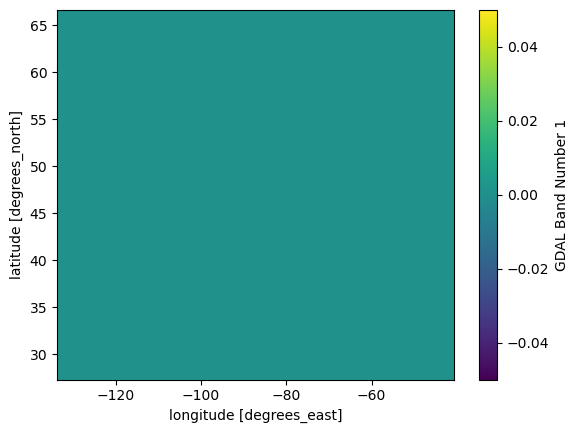

In [19]:
# read into an xarray
ds = xr.open_dataset(response.read(), engine='scipy').load()
# print the header for the DataArray
print(ds)
ds['Band1'].plot()
# dss = ds.expand_dims(time=[first])
# dss['Band1'].plot()

In [20]:
def plot_dataset(dataset : xr.Dataset):
    # First we specify Coordinate Refference System for Map Projection
    # We will use Mercator, which is a cylindrical, conformal projection. 
    # It has bery large distortion at high latitudes, cannot 
    # fully reach the polar regions.
    projection = ccrs.Mercator()
    # Specify CRS, that will be used to tell the code, where should our data be plotted
    crs = ccrs.PlateCarree()
    # Now we will create axes object having specific projection 
    plt.figure(figsize=(16,9), dpi=150)
    ax = plt.axes(projection=projection, frameon=True)
    # Draw gridlines in degrees over Mercator map
    gl = ax.gridlines(crs=crs, draw_labels=True,
                    linewidth=.6, color='gray', alpha=0.5, linestyle='-.')
    gl.xlabel_style = {"size" : 7}
    gl.ylabel_style = {"size" : 7}
    # To plot borders and coastlines, we can use cartopy feature
    import cartopy.feature as cf
    ax.add_feature(cf.COASTLINE.with_scale("50m"), lw=0.5)
    ax.add_feature(cf.BORDERS.with_scale("50m"), lw=0.3)

    # Now, we will specify extent of our map in minimum/maximum longitude/latitude
    # Note that these values are specified in degrees of longitude and degrees of latitude
    # However, we can specify them in any crs that we want, but we need to provide appropriate
    # crs argument in ax.set_extent
    lon_min = -133.7
    lon_max = -40.7
    lat_min = 27.3
    lat_max = 66.6

    ##### WE ADDED THESE LINES #####
    cbar_kwargs = {'orientation':'vertical', 'shrink':0.6, "pad" : .05, 'aspect':40}
    dataset["Band1"].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, vmax=50, levels=8)
    ################################

    # crs is PlateCarree -> we are explicitly telling axes, that we are creating bounds that are in degrees
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
    plt.title("Preciptation")
    plt.show()

    # hvplot can be used to show an interactive map of the xarray (tip: hover your cursor over the plot)
    # ds.sel(time='2024-09-05 13:00:00').hvplot(width=800, height=700, cmap='viridis', cnorm='linear')

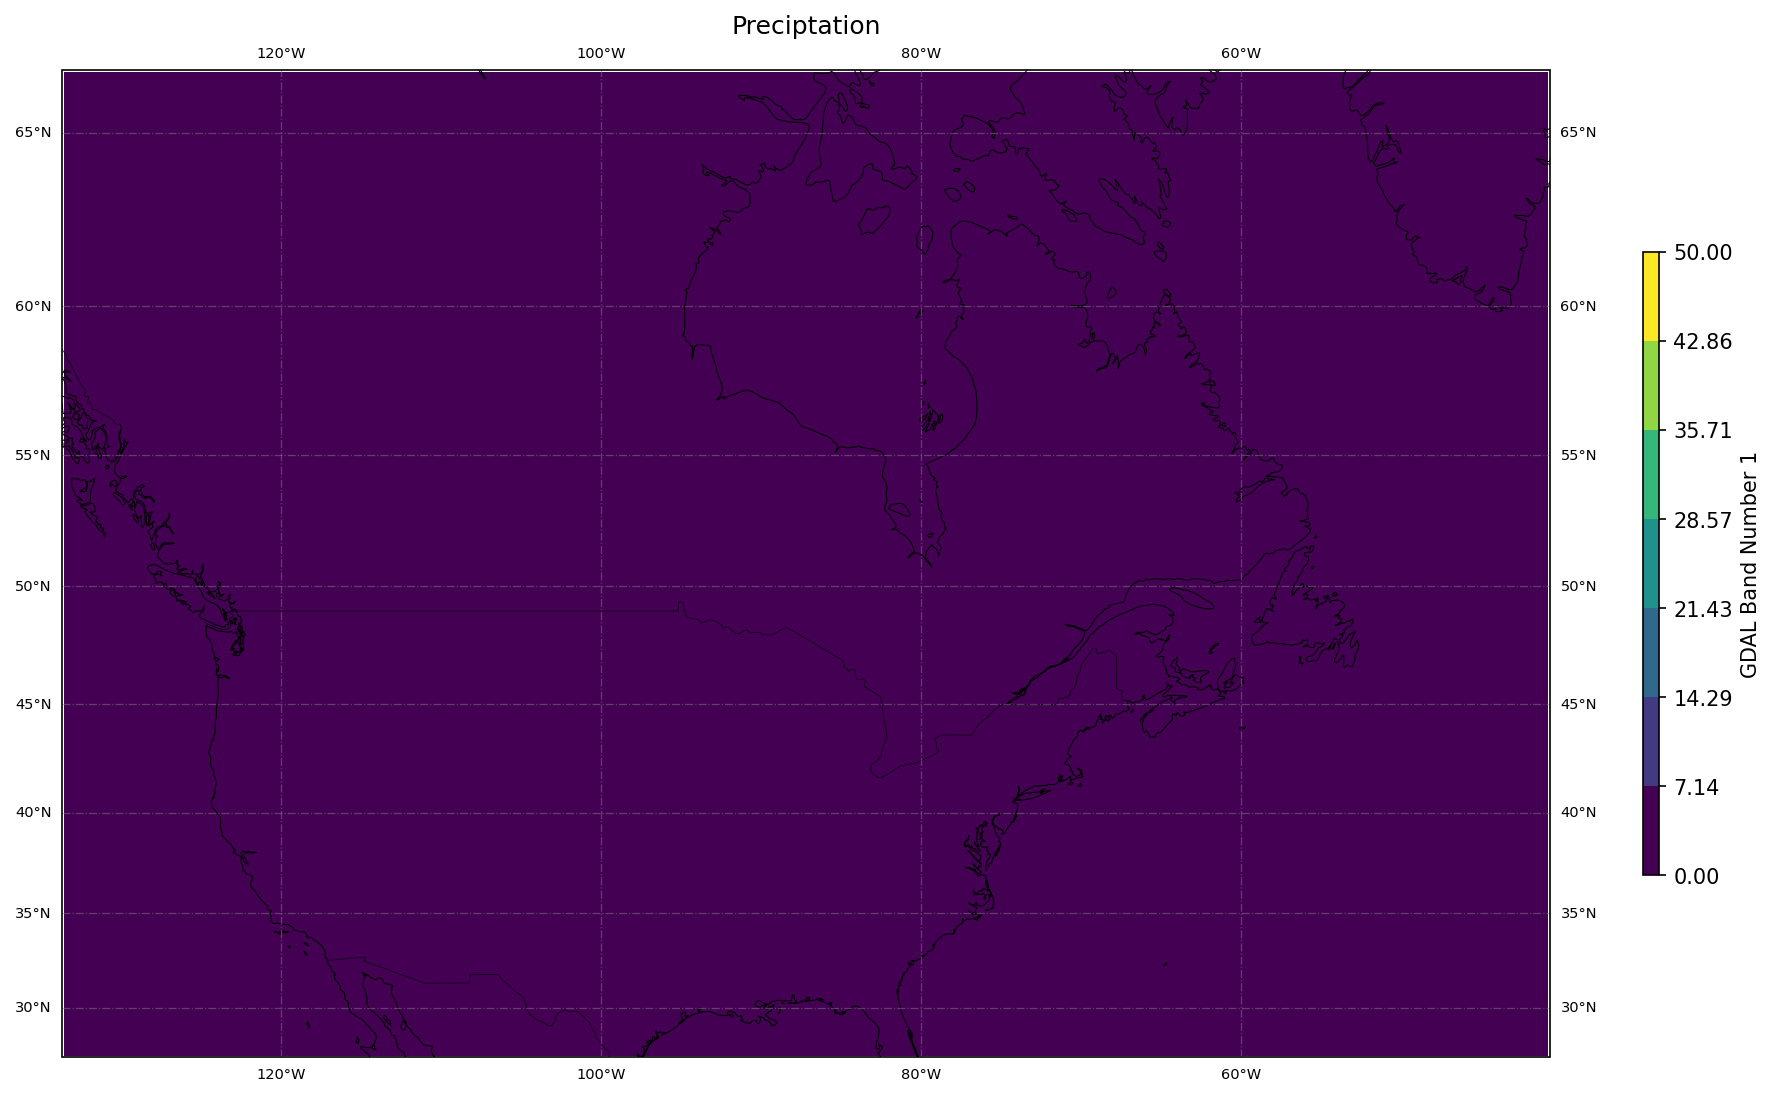

In [21]:
plot_dataset(dataset=ds)

In [456]:
# convert the datetime string to a datetime object
# iso_format = "%Y-%m-%dT%H:%M:%SZ"
# oldestf = datetime.strptime(first, iso_format)
# oldestf

datetime.datetime(2025, 1, 11, 12, 0)

In [457]:
# # remove the non-numerical characters from the datetime interval and convert to an integer
# intvl = int(re.sub(r'\D', '', interval))
# intvl

24

In [274]:
# # find the datetime object for the first available forecast hour
# firsthr = oldestf + timedelta(hours=intvl)
# # convert back to a string for the request
# first_fcasthr = datetime.strftime(firsthr, iso_format)
# first_fcasthr # first available time from the most recent forecast

'2025-01-11T06:00:00Z'

In [275]:
# wcs = WebCoverageService(
#     f'https://geo.weather.gc.ca/geomet?&SERVICE=WCS&COVERAGEID={layer_name}', 
#     auth=Authentication(username=login['Username'], password=login['Password']),
#     version='2.0.1',
#     timeout=300
# )

# response = wcs.getCoverage(
#     identifier=[layer_name], 
#     format='image/netcdf', 
#     outputcrs='EPSG:102998',
#     subsettingcrs='EPSG:102998', 
#     subsets=zone_extraction,
#     interpolation='nearest'
# )
    
# # read into an xarray
# ds = xr.open_dataset(response.read(), engine='scipy').load()

# # select data layer for plotting later
# da = ds['Band1']

In [282]:
# da.sum()

<xarray.DataArray 'Band1' ()>
array(0., dtype=float32)

In [217]:
# layer_name = 'High Resolution Deterministic Precipitation Analysis (HRDPA) [2.5 km]'
# # layer_name = 'Regional Deterministic Precipitation Analysis (RDPA) [10 km]'

# # use username and password parameters individually
# # wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS&LAYERS={layer_name}',
# wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS',
#                     version='1.3.0',
#                     username=login['Username'],
#                     password=login['Password'],
#                     timeout=300)

# # let's check what data are available for the Water Cycle Prediction System (WCPS)
# for key in list(wms.contents.keys()):
#     if "Precipitation" in key:
#         print(key)





In [214]:
# layer_name = 'HRDPA_2.5km_Precip-Accum24h-T12Z'
# wcs = WebCoverageService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WCS&COVERAGEID={layer_name}',
#                          auth=Authentication(username=login['Username'], password=login['Password']),
#                          version='2.0.1',
#                          timeout=300
#                          )

In [215]:
# # layer details
# for key, value in vars(wcs[layer_name]).items():
#     if value is not None:  # not all layers have values for the full set of available details
#         print(key)  # print the attribute name
#         # print(getattr(wms[layer_name], key))  # dynamically access the value of the attribute using getattr


In [216]:
# # let's have a look at some of the details
# print(wms[layer_name].title)
# print(wms[layer_name].dimensions)

In [198]:
# # Assuming 'wms[layer_name]._children' contains a list of ContentMetadata objects
# children = getattr(wms[layer_name], "_children", [])

# # Iterate over each ContentMetadata object in the list
# for child in children:
#     print(f"ContentMetadata Object: {child}")

#     # Use vars() or dir() to inspect the attributes of each ContentMetadata object
#     for key, value in vars(child).items():
#         if value is not None:  # Only print attributes with values
#             print(f"  {key}: {value}")


In [219]:
# # time metadata is stored in the dimensions attribute
# wms[layer_name].boundingBox

In [220]:
# from pyproj import CRS, Transformer

# # Example proj string for EPSG:102998 (check its actual definition)
# source_crs = CRS.from_proj4("+proj=longlat +datum=WGS84 +no_defs")  # Replace with actual proj string
# dest_crs = CRS.from_epsg(4326)  # Destination: WGS84 (EPSG:4326)

# # Continue as before with transformation
# transformer = Transformer.from_crs(source_crs, dest_crs, always_xy=True)


# # Original bounding box: (min_x, min_y, max_x, max_y)
# bounding_box = (-133.7, 27.3, -40.7, 66.6)

# # Convert corners of bounding box from EPSG:102998 to EPSG:4326
# min_lon, min_lat = transformer.transform(bounding_box[0], bounding_box[1])
# max_lon, max_lat = transformer.transform(bounding_box[2], bounding_box[3])

# print(f"Reprojected Bounding Box: ({min_lon}, {min_lat}, {max_lon}, {max_lat})")



In [237]:
# # formatting the reference time information
# # first= wms[layer_name].dimensions['time']['values'][0]
# # last= wms[layer_name].dimensions['time']['values'][-1]
# first, last, interval = wms[layer_name].dimensions['time']['values'][0].split('/')

# print('The first forecast issue is available at: ' + first)
# print('The last forecast issue is available at: ' + last)
# print('The forecast intervals are every: ' + interval)

In [238]:
# # looking at the default reference time
# wms[layer_name].dimensions['time']['default']

In [239]:
# wms[layer_name].dimensions['time']['values']

In [240]:
# # formatting the time information
# first, last, interval = wms[layer_name].dimensions['time']['values'][0].split('/')
# print('The first datetime available is: ' + first)
# print('The last datetime available is: ' + last)
# print('The hourly interval between available times is: ' + interval)

In [241]:
# # let's print the operations available from the wms and the product formatting options
# for op in wms.operations:
#     print(op.name, op.formatOptions)


In [247]:
# zone_extraction = [('lat', min_lat, max_lat), ('lon', min_lon, max_lon)]


# wcs = WebCoverageService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WCS&COVERAGEID={layer_name}',
#                          auth=Authentication(username=login['Username'], password=login['Password']),
#                          version='2.0.1',
#                          timeout=300
#                          )

# # layer details
# for key, value in vars(wcs[layer_name]).items():
#     if value is not None: # not all layers have values for the full set of available details
#         print(key) # let's just print the details applicable to this layer




In [13]:
# print the "abstract" for the GeoMet WCS
# print(wcs.identification.abstract)

In [14]:
# # some additional wcs metadata
# print("URL: " + wcs.url)
# print("Version: " + wcs.version)
# print("Provider: " + wcs.provider.name)
# print("Provider URL: " + wcs.provider.url)

In [15]:
# # let's print the operations available from the wms and the product formatting options
# for op in wcs.operations:
#     print(op.name, op.formatOptions)

In [248]:
# response = wcs.getCoverage(identifier=[layer_name],
#                            format='image/netcdf',
#                            subsettingcrs='EPSG:102998',  # Default and recommended crs
#                            subsets = [('lat', min_lat, max_lat), ('lon', min_lon, max_lon)],)
# print(dir(response))
# # exception_report = response.read()
# # print(exception_report.decode())  # Decode the bytes to a human-readable string


In [249]:
# # note the lack of time info
# print(response.info())
# print(response.geturl())
# print(response.info()['Content-Disposition'])

In [250]:
# # read into an xarray
# ds = xr.open_dataset(response.read(), engine='scipy').load()
# # print the header for the DataArray
# ds.head(5)

In [18]:
# # note the lack of time info
# response.geturl()
# response.info()['Content-Disposition']

In [19]:
# first

In [20]:
# interval

In [98]:
# convert the datetime string to a datetime object
iso_format = "%Y-%m-%dT%H:%M:%SZ"
oldestf = datetime.strptime(first, iso_format)
oldestf
llla = datetime.strptime(last, iso_format)
llla

datetime.datetime(2025, 2, 10, 12, 0)

In [99]:
# remove the non-numerical characters from the datetime interval and convert to an integer
intvl = int(re.sub(r'\D', '', interval))
intvl

24

In [183]:
# # find the datetime object for the first available forecast hour
# firsthr = oldestf + timedelta(hours=intvl)
# # convert back to a string for the request
# first_fcasthr = datetime.strftime(firsthr, iso_format)
# first_fcasthr # first available time from the most recent forecast
# fff = datetime.strftime(oldestf, iso_format)
# fff
# lll = datetime.strftime(llla, iso_format)
# lll
# firsthr

datetime.datetime(2025, 1, 11, 12, 0)

In [187]:
# # redo the response with the DIM_REFERENCE_TIME and TIME arguments
# response = wcs.getCoverage(identifier = [layer_name], 
#                     format = 'image/netcdf', 
#                     subsettingcrs = 'EPSG:4326', 
#                     subsets = [('lat', 48.0, 52.0), ('lon', -98.0, -92.0)], 
#                     DIM_REFERENCE_TIME=first, # capitalization here is important
#                     TIME=fff # capitalization here is important
#                    )

# response.info()['Content-Disposition']

wcs = WebCoverageService(
    f'https://geo.weather.gc.ca/geomet?&SERVICE=WCS&COVERAGEID={layer_name}', 
    auth=Authentication(username=login['Username'], password=login['Password']),
    version='2.0.1',
    timeout=300
)

response = wcs.getCoverage(
    identifier=[layer_name], 
    format='image/netcdf', 
    outputcrs='EPSG:102998',
    subsettingcrs='EPSG:102998', 
    subsets=zone_extraction,
    interpolation='nearest'
)
    
# read into an xarray
ds = xr.open_dataset(response.read(), engine='scipy').load()

# select data layer for plotting later
da = ds['Band1']

In [193]:
# # read into an xarray
# ds = xr.open_dataset(response.read()).load()
# print(da)
# add the time metadata as a new dimension and coordinate
dss = ds.expand_dims(time=[last])
# print the header for the DataArray, note the new time information
dss.head

<bound method Dataset.head of <xarray.Dataset>
Dimensions:  (time: 1, lat: 1288, lon: 2538)
Coordinates:
  * time     (time) object '2025-02-10T12:00:00Z'
  * lat      (lat) float64 27.32 27.35 27.38 27.41 ... 66.49 66.52 66.55 66.58
  * lon      (lon) float64 -133.7 -133.6 -133.6 -133.6 ... -40.79 -40.75 -40.72
Data variables:
    Band1    (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    GDAL_TIFFTAG_RESOLUTIONUNIT:  2
    GDAL_TIFFTAG_XRESOLUTION:     72.0
    GDAL_TIFFTAG_YRESOLUTION:     72.0
    Conventions:                  CF-1.5
    GDAL:                         GDAL 3.5.2, released 2022/09/02
    history:                      Tue Feb 11 08:41:21 2025: GDAL CreateCopy( ...>

In [26]:
# # add the reference time as an attribute of Band1
# ds.Band1.attrs['reference_time'] = first
# ds.Band1.attrs

PLOT

In [27]:
layer_name = 'DHPS_1km_RiverDischarge'

# first querying the WMS for time metadata
wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS&LAYERS={layer_name}',
                    version='1.3.0',
                    auth=Authentication(username=login['Username'], password=login['Password']),
                    timeout=300)

first_datetime, last_datetime, datetime_interval = wms[layer_name].dimensions['time']['values'][0].split('/')
oldest_fcast, newest_fcast, issue_interval = wms[layer_name].dimensions['reference_time']['values'][0].split('/')

iso_format = "%Y-%m-%dT%H:%M:%SZ"

# convert dates to datetime objects
first = datetime.strptime(first_datetime, iso_format)
print(first)
last = datetime.strptime(last_datetime, iso_format)

# remove anything that isn't a number from the datetime interval (time between forecasts)
intvl = int(re.sub(r'\D', '', datetime_interval))

# create a list of forecast datetimes (we will add these to the requested data)
fcasthrs = [first]
while first < last:
    first = first + timedelta(hours=intvl)
    fcasthrs.append(first)

# create a list of iso formatted forecast datetime strings (we will use these in the WCS requests)
fcasthrs_str = [datetime.strftime(hr, iso_format) for hr in fcasthrs]

2024-09-11 01:00:00


In [28]:
wcs = WebCoverageService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WCS&COVERAGEID={layer_name}', 
                    auth=Authentication(username=login['Username'], password=login['Password']),
                    version='2.0.1',
                    timeout=300
                    )

# for each forecast hour, make a WCS request
arrys = []

zone_extraction = []
lat_bounds = [43.0, 53.5]
lon_bounds = [-81.5, -57.0]
zone_extraction = [('lat', lat_bounds[0], lat_bounds[1]), ('lon', lon_bounds[0], lon_bounds[1])]

for i, hr in enumerate(fcasthrs_str):
    response = wcs.getCoverage(identifier = [layer_name], 
                        format = 'image/netcdf', 
                        subsettingcrs = 'EPSG:4326', 
                        subsets = zone_extraction,
                        DIM_REFERENCE_TIME=newest_fcast, 
                        TIME=hr 
                       )
    
    # read into an xarray
    ds = xr.open_dataset(response.read()).load()
    
    # add the time metadata as a new dimension and coordinate
    ds = ds.expand_dims(time=[fcasthrs[i]])
    
    # append to list of xarrays
    arrys.append(ds)
    
fcasts = xr.concat([ds for ds in arrys], dim='time')

In [29]:
# checking to see that the time and lat/lon dimensions look sensible
fcasts.head()

<xarray.Dataset>
Dimensions:  (time: 5, lat: 5, lon: 5)
Coordinates:
  * time     (time) datetime64[ns] 2024-09-11T01:00:00 ... 2024-09-11T05:00:00
  * lat      (lat) float64 43.0 43.01 43.02 43.03 43.04
  * lon      (lon) float64 -81.5 -81.49 -81.48 -81.47 -81.46
Data variables:
    crs      (time) |S1 b'' b'' b'' b'' b''
    Band1    (time, lat, lon) float32 0.01566 0.001573 ... 0.1123 0.002613
Attributes:
    GDAL_TIFFTAG_RESOLUTIONUNIT:  2
    GDAL_TIFFTAG_XRESOLUTION:     72.0
    GDAL_TIFFTAG_YRESOLUTION:     72.0
    Conventions:                  CF-1.5
    GDAL:                         GDAL 3.5.2, released 2022/09/02
    history:                      Wed Sep 11 22:09:53 2024: GDAL CreateCopy( ...

In [30]:
type(ds.sel(time=first)['Band1'])
# print(ds['Band1'])


xarray.core.dataarray.DataArray

In [31]:
ds.sel(time=first)

<xarray.Dataset>
Dimensions:  (lat: 1237, lon: 2466)
Coordinates:
    time     datetime64[ns] 2024-09-17
  * lat      (lat) float64 43.0 43.01 43.02 43.03 ... 53.47 53.48 53.49 53.5
  * lon      (lon) float64 -81.5 -81.49 -81.48 -81.47 ... -57.02 -57.01 -57.0
Data variables:
    crs      |S1 b''
    Band1    (lat, lon) float32 0.01181 0.001209 0.001285 ... 0.0 0.0 0.0
Attributes:
    GDAL_TIFFTAG_RESOLUTIONUNIT:  2
    GDAL_TIFFTAG_XRESOLUTION:     72.0
    GDAL_TIFFTAG_YRESOLUTION:     72.0
    Conventions:                  CF-1.5
    GDAL:                         GDAL 3.5.2, released 2022/09/02
    history:                      Wed Sep 11 22:14:11 2024: GDAL CreateCopy( ...

In [32]:
# lon_min = -71.8
# lon_max = -70.2
# lat_min = 45.8
# lat_max = 47

def plot_dataset(dataset : xr.Dataset):
    # First we specify Coordinate Refference System for Map Projection
    # We will use Mercator, which is a cylindrical, conformal projection. 
    # It has bery large distortion at high latitudes, cannot 
    # fully reach the polar regions.
    projection = ccrs.Mercator()
    # Specify CRS, that will be used to tell the code, where should our data be plotted
    crs = ccrs.PlateCarree()
    # Now we will create axes object having specific projection 
    plt.figure(figsize=(16,9), dpi=150)
    ax = plt.axes(projection=projection, frameon=True)
    # Draw gridlines in degrees over Mercator map
    gl = ax.gridlines(crs=crs, draw_labels=True,
                    linewidth=.6, color='gray', alpha=0.5, linestyle='-.')
    gl.xlabel_style = {"size" : 7}
    gl.ylabel_style = {"size" : 7}
    # To plot borders and coastlines, we can use cartopy feature
    import cartopy.feature as cf
    ax.add_feature(cf.COASTLINE.with_scale("50m"), lw=0.5)
    ax.add_feature(cf.BORDERS.with_scale("50m"), lw=0.3)

    # Now, we will specify extent of our map in minimum/maximum longitude/latitude
    # Note that these values are specified in degrees of longitude and degrees of latitude
    # However, we can specify them in any crs that we want, but we need to provide appropriate
    # crs argument in ax.set_extent
    lon_min = -71.8
    lon_max = -70.2
    lat_min = 45.8
    lat_max = 47

    ##### WE ADDED THESE LINES #####
    cbar_kwargs = {'orientation':'vertical', 'shrink':0.6, "pad" : .05, 'aspect':40}
    dataset["Band1"].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, vmax=4, levels=8)
    ################################

    # crs is PlateCarree -> we are explicitly telling axes, that we are creating bounds that are in degrees
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
    plt.title("Streamflow")
    plt.show()

    # hvplot can be used to show an interactive map of the xarray (tip: hover your cursor over the plot)
    # ds.sel(time='2024-09-05 13:00:00').hvplot(width=800, height=700, cmap='viridis', cnorm='linear')

    



In [76]:
# Create copy of the data so we maintain original data
cropped_dataset = deepcopy(ds.sel(time=first)) 
cropped_dataset

1237


In [75]:

cropped_dataset = cropped_dataset.sel(
        lat=slice(45.8, 47), 
        lon=slice(-71.8, -70.2)
    )
# print(cropped_dataset['Band1'])
print('\n')
# result = deepcopy(cropped_dataset)
result = np.where(cropped_dataset['Band1']>0, cropped_dataset.to_array, 0)
print(len(result))

# np.log10(result, out=result, where=result > 0)
# print(result)
# cropped_dataset["Band1"] = np.log10(cropped_dataset["Band1"]) 
# cropped_dataset["Band1"]



141


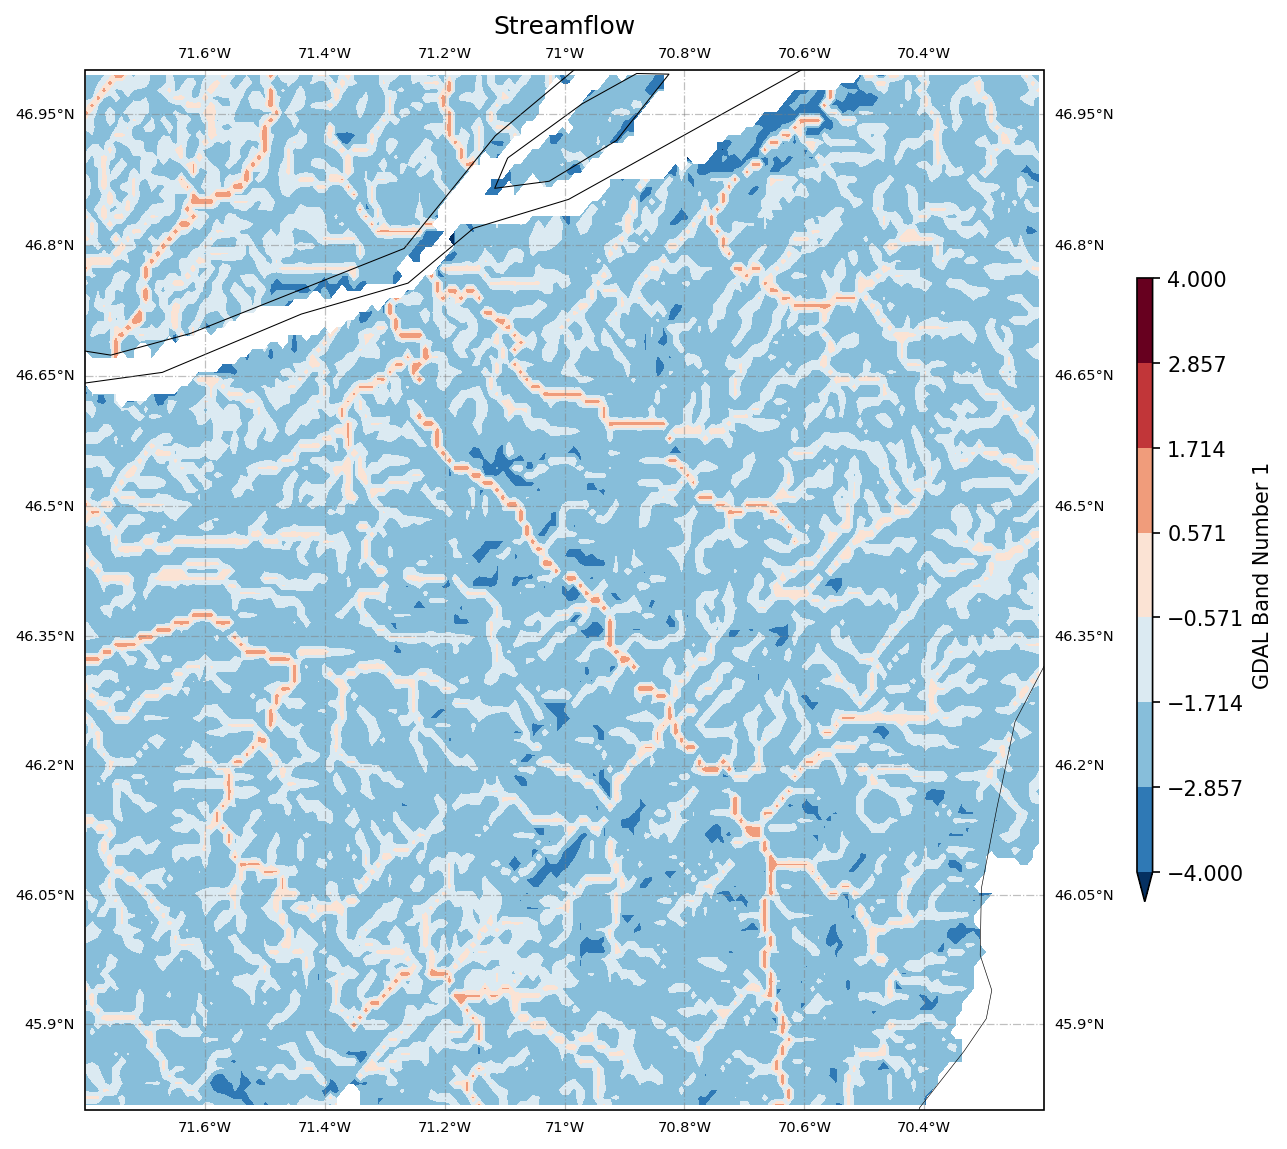

In [ ]:
# plot_dataset(ds.sel(time=first))
plot_dataset(cropped_dataset)


In [3]:
import numpy as np
arr = np.array([1, 2, 3, 4, 5, 6, 2, 0 ,8, 5, 6])
print(arr)
result = np.zeros_like(arr, dtype=float) 
print(result) 


[1 2 3 4 5 6 2 0 8 5 6]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
np.log10(arr, where=arr>0)

array([0.00000000e+00, 3.01029996e-01, 4.77121255e-01, 6.02059991e-01,
       6.98970004e-01, 7.78151250e-01, 3.01029996e-01, 9.80100000e+02,
       9.03089987e-01, 6.98970004e-01, 7.78151250e-01])

In [14]:
from typing import Union

In [15]:
layers = [""] * 3
layers[0] = "EHPS_1km_RiverDischarge-Min3h"
layers[1] = "EHPS_1km_RiverDischarge-Min6h"
layers[2] = "EHPS_1km_RiverDischarge-Min24h" 

In [62]:
def fcst_times_from_wms(
        layers: list[str], 
        username: str=None,
        password: str=None,
    ) -> Union[str, list[str]]:
    """Retrieves the forecast time metadata from the WebMapService for the 
    GeoMet layer (product) of interest.

    Parameters
    ----------
    layers : list [str]
        Name of the GeoMet layer.
    username : str, optional
        Username to access secured layer from WMS API, by default None.
    password : str, optional
        Password to access secured layer from WMS API, by default None.

    Returns
    -------
    Union[str, list[str]]
        The issuse / publication timestamp for the latest forecast.
        A list of timestamps corresponding to the latest forecast's timesteps.
    """
    # 3 layers for the 3 days we will be querying
    first = [''] * len(layers)
    last = [None] * len(layers)
    intvl = [None] * len(layers)
    end_of_day = [None] * len(layers)

    # create a list of forecast datetimes
    hrs = []

    for i in range(0, len(layers)):
        # create WMS object
        wms = WebMapService(
            f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS&LAYERS={layers[i]}',
            version='1.3.0',
            auth=Authentication(username=username, password=password),
            timeout=300
        )

        layer_metadata = wms[layers[i]]
        name = layers[i].split('_')    

        if name[0] == "DHPS" or name[0] == "DHPS-Analysis" or name[0] == "EHPS-Analysis":
            # oldest_fcast = the oldest forecast available from GeoMet, typically b/w 2 and 3 weeks old
            # latest_fcast = the most recently created forecast
            # issue_interval = how frequently the forecasts are published
            oldest_fcast, latest_fcast, issue_interval = layer_metadata.dimensions['reference_time']['values'][0].split('/')

        elif name[0] == "EHPS":
            # oldest_fcast = the oldest forecast available from GeoMet, typically the last couple hours
            # latest_fcast = the most recently created forecast
            # oldest_fcast= wms[layer_name].dimensions['reference_time']['values'][0]
            latest_fcast= layer_metadata.dimensions['reference_time']['values'][-1]

        # the following variables correspond to the latest_fcast issue
        # first_time = the first forecast datetime
        # last_time = the last datetime in the forecast i.e. the extent of the forecast horizon
        # time_interval = the temporal resolution of the forecast
        first_time, last_time, time_interval = layer_metadata.dimensions['time']['values'][0].split('/')

        iso_format = "%Y-%m-%dT%H:%M:%SZ"

        # remove anything that isn't a number from the datetime interval (time between forecasts)
        intvl[i] = int(re.sub(r'\D', '', time_interval))

        # convert date strings to datetime objects
        if i == 0:
            first[i] = datetime.strptime(first_time, iso_format)
        else:
            if i == len(layers)-1:
                first[i] = first[i-1] - timedelta(hours=intvl[i-1])
            else:
                first[i] = first[i-1] - timedelta(hours=intvl[i-1]) + timedelta(hours=intvl[i])
        last[i] = datetime.strptime(last_time, iso_format)

        end_of_day[i] = first[i] + timedelta(hours=(intvl[i] * (24/intvl[i])))

        if i < len(layers):
            # update the list of forecast dates
            while first[i] < end_of_day[i]:
                hrs.append(first[i])
                first[i] = first[i] + timedelta(hours=intvl[i])
        

    # create a list of ISO formatted forecast datetime strings
    fcasthrs = [datetime.strftime(hr, iso_format) for hr in hrs]
    fcasthrs.pop()

    return latest_fcast, fcasthrs

In [63]:
x, y = fcst_times_from_wms(layers=layers, username=login['Username'], password=login['Password'],)
print(x)
print(y)

2024-09-23T00:00:00Z
['2024-09-23T03:00:00Z', '2024-09-23T06:00:00Z', '2024-09-23T09:00:00Z', '2024-09-23T12:00:00Z', '2024-09-23T15:00:00Z', '2024-09-23T18:00:00Z', '2024-09-23T21:00:00Z', '2024-09-24T00:00:00Z', '2024-09-24T06:00:00Z', '2024-09-24T12:00:00Z', '2024-09-24T18:00:00Z', '2024-09-25T00:00:00Z']
